In [2]:
from flytekit.sdk.types import Types
from flytekit.common import utils
from flytekit.common.workflow_execution import SdkWorkflowExecution

from IPython.display import Image
from IPython.core.display import HTML 

In [19]:
wf = SdkWorkflowExecution.fetch(project="flytekubecondemo2019", domain="development", name="gt1785aotr")
print(wf.outputs)

{'ground_truths': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [23]:
wf = SdkWorkflowExecution.fetch(project="flytekubecondemo2019", domain="development", name="f1487e14d159749d0a9f")
print(wf.outputs["confusion_matrix_image"])

ERROR:root:Error from command '['aws', 's3', 'cp', 's3://lyft-modelbuilder/metadata/propeller/staging/flytekubecondemo2019-development-f1487e14d159749d0a9f/end-node/data/outputs.pb', '/var/folders/lh/1lwrhs7j7xj69b4hdr3k1d800000gp/T/8k2u26de/outputs.pb']':
b'fatal error: An error occurred (400) when calling the HeadObject operation: Bad Request\n'



FlyteAssertion: Failed to get data from s3://lyft-modelbuilder/metadata/propeller/staging/flytekubecondemo2019-development-f1487e14d159749d0a9f/end-node/data/outputs.pb to /var/folders/lh/1lwrhs7j7xj69b4hdr3k1d800000gp/T/8k2u26de/outputs.pb (recursive=False).

Original exception: Called process exited with error code: 1.  Stderr dump:

b'fatal error: An error occurred (400) when calling the HeadObject operation: Bad Request\n'

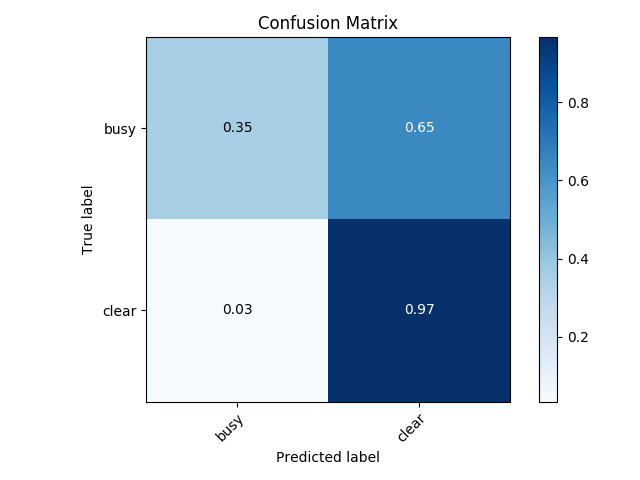

In [22]:
local_file = "/tmp/cm-4.png"
wf.outputs["confusion_matrix_image"].download(local_file)
from IPython.display import Image
Image(filename=local_file)